In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Some calculation for the LHF coupling and separation across spatial scales.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import glob
import sys; sys.path.insert(1, '/home/alessandro/thesis_material/EURECA_scripts')
import geometry as gm
import warnings; warnings.filterwarnings("ignore")
import plotdistr

In [3]:
def local_variance(field,sigma):
    bar = gm.nan_gaussian_filter(field**2,sigma)
    return bar

def local_covariance(field_a,field_b,sigma):
    bar = gm.nan_gaussian_filter(field_a*field_b,sigma)
    return bar

In [4]:
from scipy.stats import linregress

def density_scatter(x,y,xlabel,ylabel):
    fig = plt.figure(figsize=(8,5))
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = plt.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap='inferno')
    cb = plt.colorbar(hb, label='counts')
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.grid()
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    plt.title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} ({lr_out[3]:.2})')
    ics = np.array([np.min(x), np.max(x)])
    plt.plot(ics,ics*lr_out[0]+lr_out[1],'r')
    
def density_scatter_ax(ax,x,y,xlabel,ylabel):
    
    x,y = x[(~np.isnan(x))&(~np.isnan(y))], y[(~np.isnan(x))&(~np.isnan(y))]
    hb = ax.hexbin(x, y, mincnt=1, gridsize=100, bins='log', cmap='inferno')
#     cb = ax.colorbar(hb, label='counts')
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel,fontsize=12)
    ax.grid()
    
    lr_out = linregress(x,y)
    print(lr_out[1])
    ax.set_title(f'r={lr_out[2]:.2f}, s={lr_out[0]:.4f} ({lr_out[3]:.2})')
    ics = np.array([np.min(x), np.max(x)])
    ax.plot(ics,ics*lr_out[0]+lr_out[1],'r')

In [5]:
# Compute the saturation pressure as in Bolton (1980), as implemented in MetPy 
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.saturation_vapor_pressure.html

B = 17.67 # 1
C = 243.5 # °C
epsilon = 0.622
    
def e_sat(t):
    e_sat0 = 611.2 # Pa
    return e_sat0 * np.exp(B*t/(C+t))

def q_sat(t,p):    
    return epsilon*e_sat(t)/(p-e_sat(t))
    
def dq_sat_dt(t,p):
    return epsilon*e_sat(t)*p*B*C/((p-e_sat(t))**2*(C+t)**2)

def dq2_sat_dt2(t,p):
    return dq_sat_dt(t,p)*(B*C/(C+t)+2*e_sat(t)*B*C/((p-e_sat(t))*(C+t))-2)/(C+t)

In [6]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [7]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
ds = ds.where(mask_lon & mask_lat, drop=True)

In [8]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [9]:
# daily variables
sst_ff = ds['SST'].groupby('XTIME.day').mean().values*seamask - 273.15 # °C
ta_ff = ds['T2'].groupby('XTIME.day').mean().values*seamask - 273.15 # °C
Dt_ff = sst_ff -  ta_ff

In [10]:
# daily variables
p0 = 101300.
qa_ff = ds['Q2'].groupby('XTIME.day').mean().values*seamask
RH_ff = qa_ff/q_sat(ta_ff,p0)

In [11]:
# daily variables
u10 = ds['U10'].groupby('XTIME.day').mean().values*seamask
v10 = ds['V10'].groupby('XTIME.day').mean().values*seamask
U_ff = np.sqrt(u10**2 + v10**2)*seamask
del u10,v10

In [12]:
# compute smooth fields and anomalies daily data - Band-pass filter
sigma = 'inf' # *3km = 150 km
sigma_sub = 0 # *3km = 60 km

sst_bar = np.zeros(sst_ff.shape); ta_bar = np.zeros(ta_ff.shape); Dt_bar = np.zeros(Dt_ff.shape) 
RH_bar = np.zeros(RH_ff.shape); qa_bar = np.zeros(qa_ff.shape); U_bar = np.zeros(U_ff.shape) 
sst_prime = np.zeros(sst_ff.shape); ta_prime = np.zeros(ta_ff.shape); Dt_prime = np.zeros(Dt_ff.shape) 
RH_prime = np.zeros(RH_ff.shape); qa_prime = np.zeros(qa_ff.shape); U_prime = np.zeros(U_ff.shape) 


for t in range(0,sst_ff.shape[0]):
    sst_bar[t] = gm.nan_gaussian_filter(sst_ff[t],sigma)*seamask
    X_prime = sst_ff[t] - sst_bar[t]
    sst_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)*seamask
    
    ta_bar[t] = gm.nan_gaussian_filter(ta_ff[t],sigma)*seamask
    X_prime = ta_ff[t] - ta_bar[t]
    ta_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)*seamask
    
    Dt_bar[t] = gm.nan_gaussian_filter(Dt_ff[t],sigma)*seamask
    X_prime = Dt_ff[t] - Dt_bar[t]
    Dt_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)*seamask
    
    qa_bar[t] = gm.nan_gaussian_filter(qa_ff[t],sigma)*seamask
    X_prime = qa_ff[t] - qa_bar[t]
    qa_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)*seamask
    
    RH_bar[t] = gm.nan_gaussian_filter(RH_ff[t],sigma)*seamask
    X_prime = RH_ff[t] - RH_bar[t]
    RH_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)*seamask
    
    U_bar[t] = gm.nan_gaussian_filter(U_ff[t],sigma)*seamask
    X_prime = U_ff[t] - U_bar[t]
    U_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)*seamask

In [13]:
'''import pandas as pd
time = pd.date_range(start='2/1/2020', end='2/29/2020')

list_vars = [sst_bar, sst_prime, ta_bar, ta_prime, qa_bar, 
             qa_prime, U_bar, U_prime, RH_bar, RH_prime]

name_vars = ['sst_bar', 'sst_prime', 'ta_bar', 'ta_prime', 'qa_bar', 
             'qa_prime', 'U_bar', 'U_prime', 'RH_bar', 'RH_prime']


if len(list_vars) == len(name_vars):
    print('var lists ok')
    ds_out = xr.Dataset(coords={'day':time})

    for i in range(len(name_vars)):
        ds_out[name_vars[i]] = xr.DataArray(list_vars[i], name=name_vars[i],\
                                            dims=['day', 'lat', 'lon'])
else:
    print('something missing in either of the two var lists')'''

"import pandas as pd\ntime = pd.date_range(start='2/1/2020', end='2/29/2020')\n\nlist_vars = [sst_bar, sst_prime, ta_bar, ta_prime, qa_bar, \n             qa_prime, U_bar, U_prime, RH_bar, RH_prime]\n\nname_vars = ['sst_bar', 'sst_prime', 'ta_bar', 'ta_prime', 'qa_bar', \n             'qa_prime', 'U_bar', 'U_prime', 'RH_bar', 'RH_prime']\n\n\nif len(list_vars) == len(name_vars):\n    print('var lists ok')\n    ds_out = xr.Dataset(coords={'day':time})\n\n    for i in range(len(name_vars)):\n        ds_out[name_vars[i]] = xr.DataArray(list_vars[i], name=name_vars[i],                                            dims=['day', 'lat', 'lon'])\nelse:\n    print('something missing in either of the two var lists')"

In [23]:
'''ds_out.attrs['description'] = 'MATTE sigma inf, daily means, bars and primes''''

In [24]:
'''ds_out.to_netcdf('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/MATTE_sigma-inf_barsprimes.nc')'''

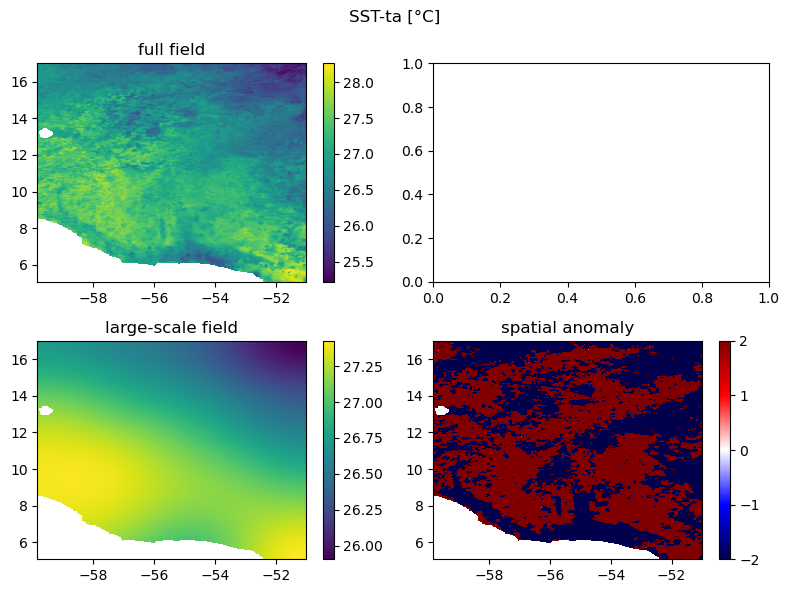

In [34]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('SST-ta [°C]')

t = 0

pc = axs[0,0].pcolormesh(lon,lat,sst_ff[t],shading='nearest')
fig.colorbar(pc,ax=axs[0,0])
axs[0,0].set_title('full field')

# axs[0,1].hist(hfx_wrf.flatten(),bins=50)

pc = axs[1,0].pcolormesh(lon,lat,sst_bar[t],shading='nearest')
fig.colorbar(pc,ax=axs[1,0])
axs[1,0].set_title('large-scale field')

pc = axs[1,1].pcolormesh(lon,lat,lambda_sst[t]*sst_prime[t],shading='nearest',cmap='seismic',vmin=-2,vmax=2)
fig.colorbar(pc,ax=axs[1,1])
axs[1,1].set_title('spatial anomaly')

plt.tight_layout()

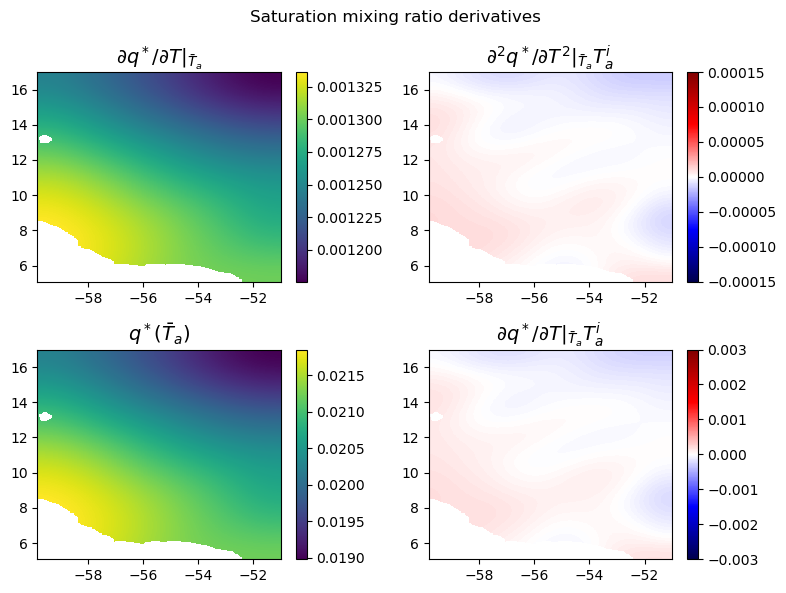

In [17]:
# Evaluate some terms involving the q_sat derivatives.
t = 0
dq_dta_bar = dq_sat_dt(ta_bar[t],p0)
dq2_dta2_bar = dq2_sat_dt2(ta_bar[t],p0)

fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.suptitle('Saturation mixing ratio derivatives')

pc = axs[0,0].pcolormesh(lon,lat,dq_dta_bar,shading='nearest')
fig.colorbar(pc,ax=axs[0,0])
axs[0,0].set_title('$\\partial q^*/\\partial T|_{ \\bar{T}_a}$',fontsize=14)

pc = axs[0,1].pcolormesh(lon,lat,dq2_dta2_bar*ta_prime[t],shading='nearest',cmap='seismic',vmin=-1.5e-4,vmax=1.5e-4)
fig.colorbar(pc,ax=axs[0,1])
axs[0,1].set_title('$\\partial^2 q^*/\\partial T^2|_{ \\bar{T}_a} T_a^i$',fontsize=14)

pc = axs[1,0].pcolormesh(lon,lat,q_sat(ta_bar[t],p0),shading='nearest')
fig.colorbar(pc,ax=axs[1,0])
axs[1,0].set_title('$q^*(\\bar{T}_a)$',fontsize=14)

pc = axs[1,1].pcolormesh(lon,lat,dq_dta_bar*ta_prime[t],shading='nearest',cmap='seismic',vmin=-3e-3,vmax=3e-3)
fig.colorbar(pc,ax=axs[1,1])
axs[1,1].set_title('$\\partial q^*/\\partial T|_{ \\bar{T}_a}  T_a^i$',fontsize=14)

plt.tight_layout()

In [13]:
# Now compute the LHF with the bulk formula and separate its large and small scale contributions.

rho_a = 1.2 # kg/m3
cp = 1005 # J/kg
Ch = 1.3e-3 # representative value of the exchange coefficient (it has a weak dependence on the wind speed)
beta = rho_a*cp*Ch


SHF_file = '/dagobah/WRF_EUREC4A/COARE35/Fluxes/FEB/01/SHF_daily_coare35_d02_2020-02'
ds_tmp = xr.open_dataset(SHF_file) # gia fatto ritaglio lonlat
hfx_coare = ds_tmp['SHF'].values*seamask
del ds_tmp

# HFX WRF
# hfx_wrf = ds['HFX'].groupby('XTIME.day').mean().values*seamask


hfx_coare_bar, hfx_coare_prime = np.zeros(hfx_coare.shape), np.zeros(hfx_coare.shape);

for t in range(0,sst_ff.shape[0]):
    hfx_coare_bar[t] = gm.nan_gaussian_filter(hfx_coare[t],sigma)
    X_prime = hfx_coare[t] - hfx_coare_bar[t]
    hfx_coare_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)


-8.753046565478485
-8.753046501886757
2.2426126921711784
2.2426127511276945


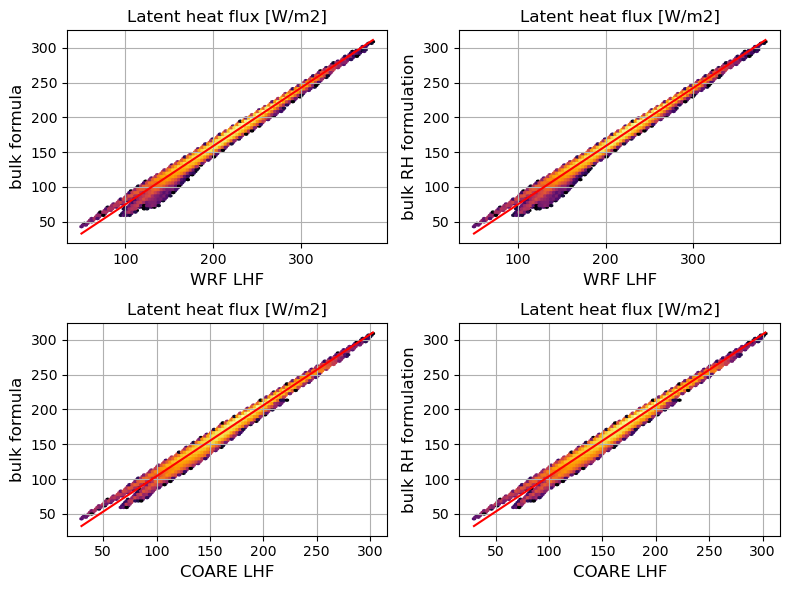

In [22]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
ax = axs.flatten()

density_scatter_ax(ax[0],hfx_wrf,hfx_dir,'WRF hfx','bulk formula')
ax[0].plot([np.min(hfx_wrf),np.max(hfx_wrf)],[np.min(hfx_wrf),np.max(hfx_wrf)],'k--')
ax[0].set_title('Sensible heat flux [W/m2]')

density_scatter_ax(ax[1],hfx_wrf,hfx_rh,'WRF hfx','bulk RH formulation')
ax[1].plot([np.min(hfx_wrf),np.max(hfx_wrf)],[np.min(hfx_wrf),np.max(hfx_wrf)],'k--')
ax[1].set_title('Sensible heat flux [W/m2]')

density_scatter_ax(ax[2],hfx_coare,hfx_dir,'COARE hfx','bulk formula')
ax[2].plot([np.min(hfx_wrf),np.max(hfx_wrf)],[np.min(hfx_wrf),np.max(hfx_wrf)],'k--')
ax[2].set_title('Sensible heat flux [W/m2]')

density_scatter_ax(ax[3],hfx_coare,hfx_rh,'COARE hfx','bulk RH formulation')
ax[3].plot([np.min(hfx_wrf),np.max(hfx_wrf)],[np.min(hfx_wrf),np.max(hfx_wrf)],'k--')
ax[3].set_title('Sensible heat flux [W/m2]')

plt.tight_layout()

In [14]:
# Compute the lambdas.

lambda_U = beta*(sst_bar - ta_bar)   #beta*(q_sat(sst_bar,p0)-RH_bar*q_sat(ta_bar,p0))
lambda_sst = beta*U_bar                       #beta*U_bar*dq_sat_dt(sst_bar,p0)
lambda_ta = -beta*U_bar

In [15]:
# Compute the total local variance of the hfx.

hfx_prime = hfx_coare_prime #hfx_dir_prime if dir_bulk else hfx_rh_prime

var_hfx = np.zeros(hfx_prime.shape)
for t in range(0,hfx_prime.shape[0]):
    var_hfx[t] = local_variance(hfx_prime[t],sigma)

In [27]:
'''if sigma_sub>0:
    ds_out = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/MATTE_band-pass_barsprimes.nc')
elif sigma=='inf':
    ds_out = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/MATTE_sigma-inf_barsprimes.nc')
else:
    ds_out = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/MATTE_passalto_barsprimes.nc')

ds_out['lhf_prime'] = xr.DataArray(lhf_prime, name='lhf_prime',dims=['day', 'lat', 'lon'])
ds_out.close()

if sigma_sub>0:
    ds_out.to_netcdf('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/MATTE_band-pass_barsprimes_new.nc')
elif sigma=='inf':
    ds_out.to_netcdf('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/MATTE_sigma-inf_barsprimes_new.nc')
else:
    ds_out.to_netcdf('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/primes/MATTE_passalto_barsprimes_new.nc')
'''

In [ ]:
## faccio questa cosa già sopra

'''# PASSA BANDA ANCHE SU VAR LOCALE
lhf_bar = np.zeros(lhf_rh.shape); lhf_prime = np.zeros(lhf_rh.shape)
for t in range(0,sst_ff.shape[0]):
    lhf_bar[t] = gm.nan_gaussian_filter(lhf_rh[t],sigma)
    X_prime = lhf_rh[t] - lhf_bar[t]
    lhf_prime[t] = gm.nan_gaussian_filter(X_prime,sigma_sub)'''

Text(0.5, 1.0, 'LHF local variance [W2/m4]')

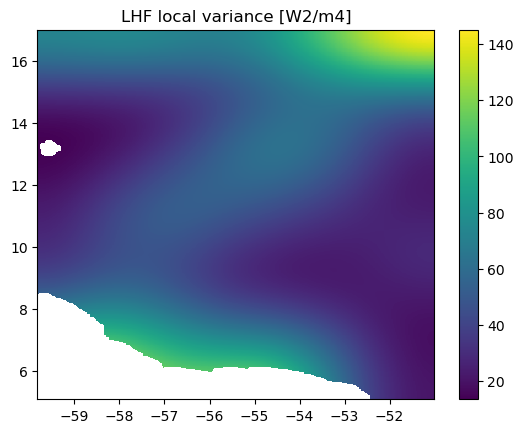

In [100]:
# pc = plt.pcolormesh(lon,lat,np.nanmean(var_lhf, axis=0),shading='nearest')
t = 1
pc = plt.pcolormesh(lon,lat,var_hfx[t],shading='nearest')
plt.colorbar(pc)
plt.title('LHF local variance [W2/m4]')

In [35]:
'''fname = 'MATTE_passalto_lhfDIR_dailyMeans_all.nc' if dir_bulk else 'MATTE_passalto_lhfRH_dailyMeans_all.nc'
ds_in = xr.open_dataset('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/'+fname)

dims = var_lhf.shape
covar_U_lhf = np.zeros(dims)
for t in range(0,sst_ff.shape[0]):
    covar_U_lhf[t] = local_covariance(U_prime[t],lhf_prime[t],sigma)
    
ds_in['covar_U_lhf'] = xr.DataArray(covar_U_lhf, name='covar_U_lhf',\
                                            dims=['day', 'lat', 'lon'])'''


In [36]:
'''ds_in.to_netcdf('/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/NEW_'+fname)'''

In [101]:
# Compute variance
dims = var_hfx.shape
var_U = np.zeros(dims); var_ta = np.zeros(dims); var_sst =  np.zeros(dims); var_RH = np.zeros(dims)
covar_U_ta = np.zeros(dims); covar_U_sst = np.zeros(dims); covar_U_RH =  np.zeros(dims)
covar_ta_sst = np.zeros(dims); covar_ta_RH = np.zeros(dims); covar_RH_sst =  np.zeros(dims)
covar_hfx_sst = np.zeros(dims); var_qa = np.zeros(dims); covar_U_q = np.zeros(dims); covar_q_sst = np.zeros(dims)
covar_U_hfx = np.zeros(dims)

for t in range(0,sst_ff.shape[0]):
    # non sst terms
    var_qa[t] = local_variance(qa_prime[t],sigma)
    var_U[t] = local_variance(U_prime[t],sigma)
    var_ta[t] = local_variance(ta_prime[t],sigma)
    var_RH[t] = local_variance(RH_prime[t],sigma)
    covar_U_ta[t] = local_covariance(U_prime[t],ta_prime[t],sigma)
    covar_U_RH[t] = local_covariance(U_prime[t],RH_prime[t],sigma)
    covar_ta_RH[t] = local_covariance(RH_prime[t],ta_prime[t],sigma)
    covar_U_q[t] = local_covariance(U_prime[t],qa_prime[t],sigma)
    covar_U_hfx[t] = local_covariance(U_prime[t],hfx_prime[t],sigma)
    
    # sst terms
    var_sst[t] = local_variance(sst_prime[t],sigma)
    covar_hfx_sst[t] = local_covariance(hfx_prime[t],sst_prime[t],sigma)
    covar_ta_sst[t] = local_covariance(sst_prime[t],ta_prime[t],sigma)
    covar_U_sst[t] = local_covariance(U_prime[t],sst_prime[t],sigma)
    covar_RH_sst[t] = local_covariance(sst_prime[t],RH_prime[t],sigma)
    covar_q_sst[t] = local_covariance(sst_prime[t],qa_prime[t],sigma)

if not dir_bulk:
    sst_terms = (lambda_sst**2*var_sst + 
                 2*lambda_sst*(lambda_U*covar_U_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst))
    non_sst_terms = (lambda_U**2*var_U + lambda_ta**2*var_ta + lambda_RH**2*var_RH + 
                     2*lambda_U*lambda_ta*covar_U_ta + 2*lambda_U*lambda_RH*covar_U_RH + 2*lambda_ta*lambda_RH*covar_ta_RH)
    var_hfx_sum = sst_terms + non_sst_terms
else:
    sst_terms = (lambda_sst**2*var_sst + 2*lambda_sst*(lambda_U*covar_U_sst + lambda_q*covar_q_sst))
    non_sst_terms = (lambda_U**2*var_U + lambda_q**2*var_qa + 2*lambda_q*lambda_U*covar_U_q)
    var_hfx_sum = sst_terms + non_sst_terms
    

# Studying Fourier spectra over the reconstruction of HFX

thus over 
$ HFX' = \lambda_{SST}\cdot SST' + \lambda_{T}\cdot T'_{2} + \lambda_{U}U' $

mind that lambdas do have a Fourier spectrum of their own, but since they are computed at larger scales results should not be affected

In [16]:
fourier_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_forced.npy')
fourier_large = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_forced_LARGE.npy')

In [51]:
def power_spectrum_2d(c, dx, dy):
    # for the moment this func cannot deal with nan
    # c is input signal
    # dx is sampling rate along x
    # dy is sampling rate along y
    kx = np.fft.fftshift(np.fft.fftfreq(c.shape[1],dx))
    ky = np.fft.fftshift(np.fft.fftfreq(c.shape[0],dy))
    ps2 = np.abs(np.fft.fft2(c-np.mean(c), norm='ortho'))**2
    
    # shift to put freq 0 in the middle (positive freq up/right - negative freq bot/left)
    ps2 = np.fft.fftshift(ps2)   
    
#     ps2 = ps2/(len(kx)*len(ky))

    kkx,kky = np.meshgrid(kx,ky)
    distance = np.sqrt(kkx**2+kky**2)
    kmax = min(kx[-1],ky[-1])
    dk = kx[1]-kx[0]
    kloop = np.arange(dk,kmax+dk,dk)
    ps2_iso = np.zeros(len(kloop))
    
    for ik,k in enumerate(kloop):
        id_k = (distance>k)&(distance<k+dk)
        ps2_iso[ik] = np.nanmean(ps2[id_k])
    return kloop, ps2_iso

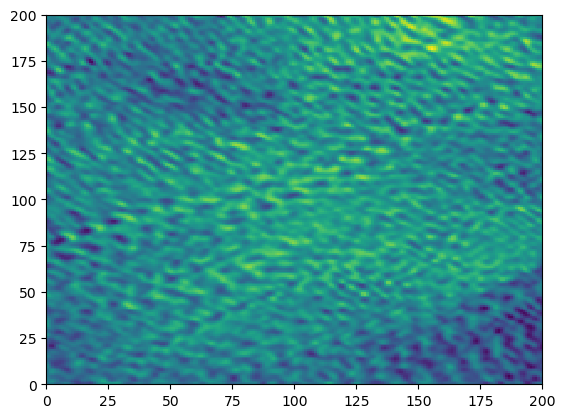

In [28]:
plt.pcolormesh(dictio_fou['U'][0])

In [54]:
dx, dy = 3, 3

varrs = {'HFX': hfx_prime, 'SST': lambda_sst*sst_prime, 'U': lambda_U*U_prime, 'T':lambda_ta*ta_prime}
dictio_fou = {}

for num, key in enumerate(varrs):
    miao = varrs[key]
    miao = miao*fourier_large
    miao = miao[~np.isnan(miao)].reshape(29, 250, 250)
    dictio_fou[key] = miao


fou_results = {}
for num, key in enumerate(dictio_fou):
    accu = np.zeros((dictio_fou[key].shape[0], dictio_fou[key].shape[1]//2))
    
    for t in range(dictio_fou[key].shape[0]):
        k, accu[t] = power_spectrum_2d(dictio_fou[key][t], dx, dy)
    
    accu = np.mean(accu, axis=0)
    fou_results[key] = accu


#######  compare F(HFX') with F(\sum terms)  #######

summy = np.zeros_like(dictio_fou['HFX'])
for var in dictio_fou:
    if var == 'HFX':
        continue
    summy = summy+dictio_fou[var]

fou_of_sum = np.zeros((summy.shape[0], summy.shape[1]//2))
for t in range(summy.shape[0]):
    k, fou_of_sum[t] = power_spectrum_2d(summy[t], dx, dy)
fou_of_sum_mean = np.mean(fou_of_sum, axis=0)



########################################


### observe day-to-day variability of spectra, before averaging out in time

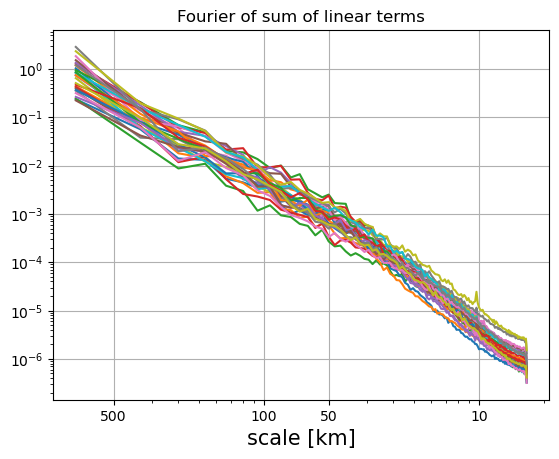

In [42]:
for t in range(fou_of_sum.shape[0]):
    plt.loglog(k, fou_of_sum[t])

plt.xticks([0.1, 1/50, 0.01, 1/500], labels=['10', '50', '100', '500'])
plt.grid()

plt.title('Fourier of sum of linear terms')
plt.xlabel("scale [km]", fontsize=15)

plt.show()

In [30]:
dictio_fou.keys()

dict_keys(['HFX', 'SST', 'U', 'T'])

### spectra of stand-alone (NO lambdas) variables

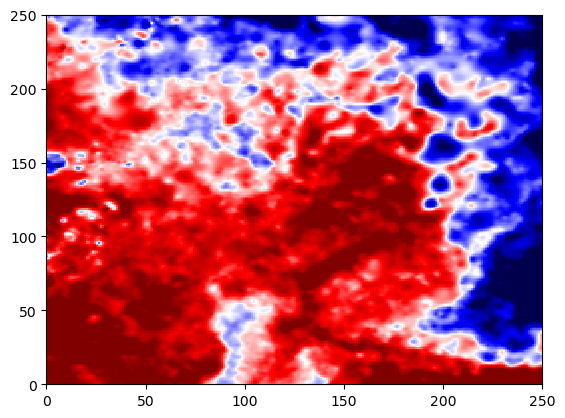

In [52]:
var_id = 'SST'
lambda_id = {'HFX': np.ones_like(hfx_prime),  'SST': lambda_sst, 'U': lambda_U, 'T':lambda_ta}

for num, key in enumerate(lambda_id):
    miao = lambda_id[key]
    miao = miao*fourier_large  
    miao = miao[~np.isnan(miao)].reshape(29, 250, 250)
    lambda_id[key] = miao
    

    
plt.pcolormesh(dictio_fou[var_id][10]/lambda_id[var_id][10], vmin=-0.5, vmax=0.5, cmap='seismic')

Text(0.5, 0, 'scale [km]')

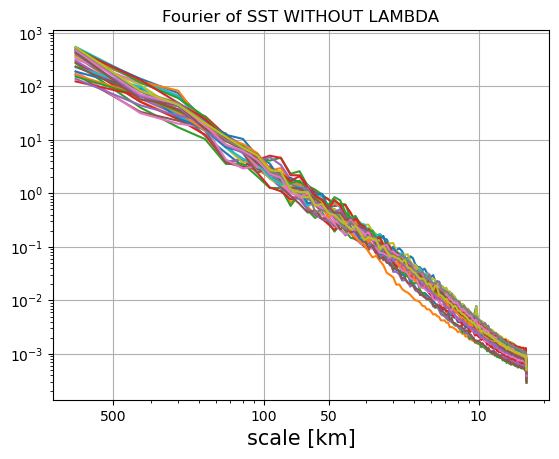

In [53]:
accu = np.zeros((dictio_fou[var_id].shape[0], dictio_fou[var_id].shape[1]//2))
    
for t in range(dictio_fou[var_id].shape[0]):
    k, accu[t] = power_spectrum_2d(dictio_fou[var_id][t]/lambda_id[var_id][t], dx, dy)

    
#################  plotting  ################

for t in range(dictio_fou[var_id].shape[0]):
    plt.loglog(k, accu[t])

plt.xticks([0.1, 1/50, 0.01, 1/500], labels=['10', '50', '100', '500'])
plt.grid()

plt.title(f'Fourier of {var_id} WITHOUT LAMBDA')
plt.xlabel("scale [km]", fontsize=15)

## spectrum of reconstruction

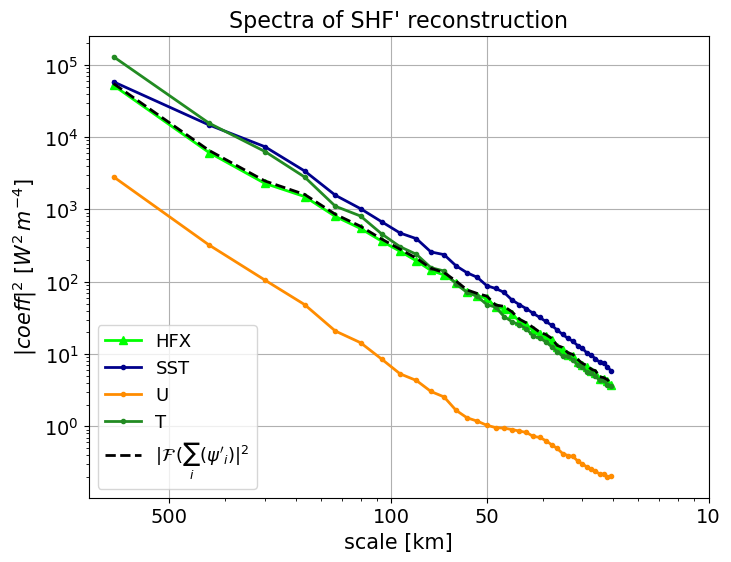

In [64]:
fig = plt.figure(figsize=(8,6))

sigma_tit = str(dx*sigma)+' km' if (sigma is not 'inf') else 'inf'
tit = "Spectra of SHF' reconstruction" #+f"sigma = {sigma}"

distances = False
x = 1/k if distances else k    # 2*np.pi/k
lower_limit, upper_limit = 20, 10000;
valid = (1/k > lower_limit) & (1/k < upper_limit)  # select only above 40km
xlab = "scale [km]" if distances else "$\lambda^{-1}$ [$km^{-1}$]"

colours = {'HFX':'lime', 'SST':'darkblue', 'U':'darkorange', 'T':'forestgreen'}
for var in varrs:
    if var is 'HFX':
        plt.loglog(x[valid], fou_results[var][valid],'^-', label=var, linewidth=2, color=colours[var])
    else:
        plt.loglog(x[valid], fou_results[var][valid],'.-', label=var, linewidth=2, color=colours[var])

####### check F(sum terms)  #######
plt.loglog(x[valid], fou_of_sum_mean[valid], '--', label="$|\mathcal{F} \, (\sum_i (\psi'_i)|^2$", linewidth=2, color='k')

plt.xticks([0.1, 1/50, 0.01, 1/500], labels=['10', '50', '100', '500'])
plt.tick_params(axis='x', labelsize=14)  # Change x-axis tick label size
plt.tick_params(axis='y', labelsize=14)  # Change y-axis tick label size
           
plt.title(tit, fontsize=16)
plt.xlabel("scale [km]", fontsize=15)
plt.ylabel('$|coeff|^2$ $[W^2\,m^{-4}]$', fontsize=15)




plt.grid('minor')
plt.legend(loc='lower left', fontsize=13)
# plt.xlim([lower_limit-5, upper_limit+10])



dirpath = '/venus/tesi_ale/plots_forced_EU/FORCED_HFX_scaling_eureca_passabanda_MATTE/'
filename = dirpath + 'forced_fourier_HFX-COARE_reconstruction.png'
# plt.savefig(filename)
del filename


plt.show()




In [23]:
fou_results['SST'][valid]/fou_results['HFX'][valid]

array([1.71460318, 1.54628783, 1.58339773, 1.32453172, 1.95551706,
       1.69477113, 1.58487404, 1.7786263 , 1.51455545, 1.65853013,
       1.34246784, 1.52338229, 1.51214399, 1.45953203, 1.48719851,
       1.45348908, 1.43061785, 1.49631711, 1.56546209, 1.48877191,
       1.45789615, 1.51907582, 1.54987914, 1.48024671, 1.51733404,
       1.50098718, 1.45606607, 1.48805922, 1.36958752])

In [29]:
dictionary_to_be_saved = fou_results.copy()
dictionary_to_be_saved['F(sum)'] = fou_of_sum
dictionary_to_be_saved['k'] = k

dictionary_to_be_saved['description'] = 'FORCED model Fourier spectra of HFX and its linear reconstruction in the fourier_forced mask'


import pickle 

with open('/venus/tesi_ale/data_EU/Fourier_spectra/forced/forced_HFX_linearExp_spectra_sigmaINF.pkl', 'wb') as f:
    pickle.dump(dictionary_to_be_saved, f)

In [57]:
dictionary_to_be_saved.keys()

dict_keys(['HFX', 'SST', 'U', 'T', 'F(sum)', 'k', 'description'])

# Assessing how well the linear expansion works

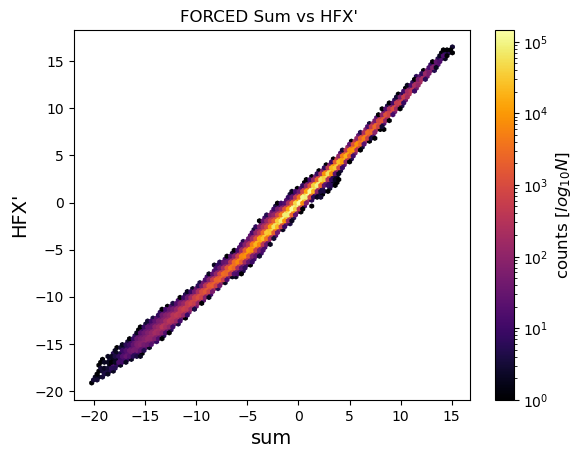

In [52]:
x = lambda_sst*sst_prime + lambda_ta*ta_prime + lambda_U*U_prime
y = hfx_prime

tit = "FORCED Sum vs HFX' "

fig = plotdistr.density_hexbin(x,y,plot_fit=False,fit=None,corcoe=None,grdsz=100,\
                     title=tit, xlabel='sum', ylabel="HFX'", colormap='inferno', pos=[0,0])

In [41]:
np.nanmin(lambda_ta)

-36956.53209279469

-0.004493946039061614
[0.06283241639492725, 5.882117103343605]


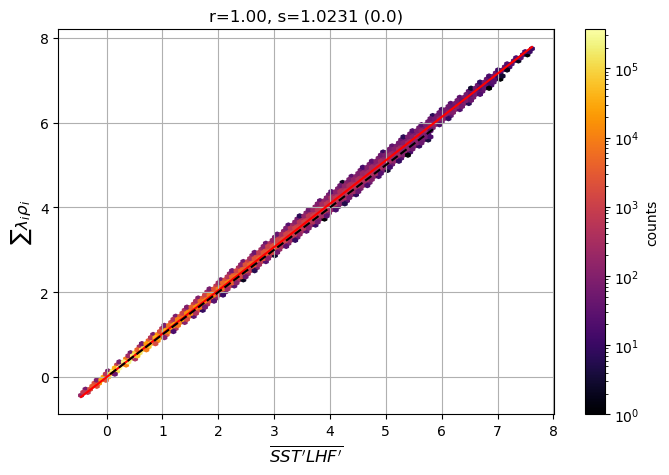

In [102]:
## checking equation above, Ago's eqn 44 
## IN THE RH FORMULATION
if not dir_bulk:
    covar_sum = lambda_U*covar_U_sst + lambda_sst*var_sst + lambda_ta*covar_ta_sst + lambda_RH*covar_RH_sst
    title = ' , RH'
else:
    covar_sum =  lambda_sst*var_sst + lambda_U*covar_U_sst + lambda_q*covar_q_sst
    title = ' , LH direct'   #

density_scatter(covar_lhf_sst, covar_sum,'$\\overline{SST\' LHF\'}$','$\\sum \\lambda_i \\rho_i$')
ics_rho = [np.nanpercentile(covar_lhf_sst,5),np.nanpercentile(covar_lhf_sst,99.9)]
print(ics_rho)
plt.plot(ics_rho,ics_rho,'k--')

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/high-pass_SSTLHF_scatterVar_LHFdir.png')

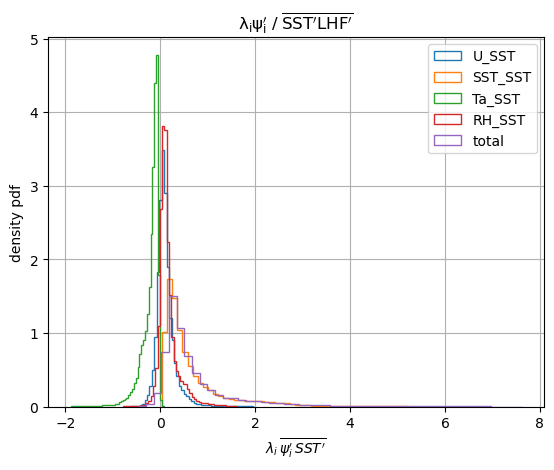

In [90]:
bins = 50

if not dir_bulk:   
    u_sst = lambda_U*covar_U_sst #/covar_lhf_sst
    sst_sst = lambda_sst*var_sst #/covar_lhf_sst
    ta_sst = lambda_ta*covar_ta_sst #/covar_lhf_sst
    rh_sst = lambda_RH*covar_RH_sst #/covar_lhf_sst

    bins = 50

    plt.hist((u_sst).flatten(),bins=bins,histtype=u'step',density=True)
    plt.hist((sst_sst).flatten(),bins=bins,histtype=u'step',density=True)
    plt.hist((ta_sst).flatten(),bins=bins,histtype=u'step',density=True)
    plt.hist((rh_sst).flatten(),bins=bins,histtype=u'step',density=True)
    plt.hist((covar_lhf_sst).flatten(),bins=bins,histtype=u'step',density=True)
    
    plt.title('$\\rm \\lambda_i \\psi_i\' \; / \; \\overline{SST\'LHF\'}$')
    plt.legend(['U_SST', 'SST_SST', 'Ta_SST', 'RH_SST', 'total'])
    plt.xlabel(r"$\lambda_i \, \overline{\psi_i' \, SST'}$")
    plt.ylabel('density pdf')

    
else:
    q_sst = lambda_q*covar_q_sst
    sst_sst = lambda_sst*var_sst
    u_sst = lambda_U*covar_U_sst
    
    plt.hist((sst_sst).flatten(),bins=bins,histtype=u'step',density=True)
    plt.hist((u_sst).flatten(),bins=bins,histtype=u'step',density=True)
    plt.hist((q_sst).flatten(),bins=bins,histtype=u'step',density=True)
    plt.hist((covar_lhf_sst).flatten(),bins=bins,histtype=u'step',density=True, edgecolor='purple', linewidth=2)
    
    plt.legend(['SST_SST', 'U_SST', 'Q_SST', 'total'])
    plt.xlim(-2,4); #plt.ylim(0, 3)
    plt.xlabel(r"$\lambda_i \, \overline{\psi_i' \, SST'}$")
    plt.ylabel('density pdf')
    plt.title('term-by-term distributions, direct formulation')
    
plt.grid(); #plt.xlim(-10,10)


# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/high-pass_150_eqn44_lhfDir_dailyMeans.png')

-0.15710576019396427
[10.526380312924864, 397.22192904765717]


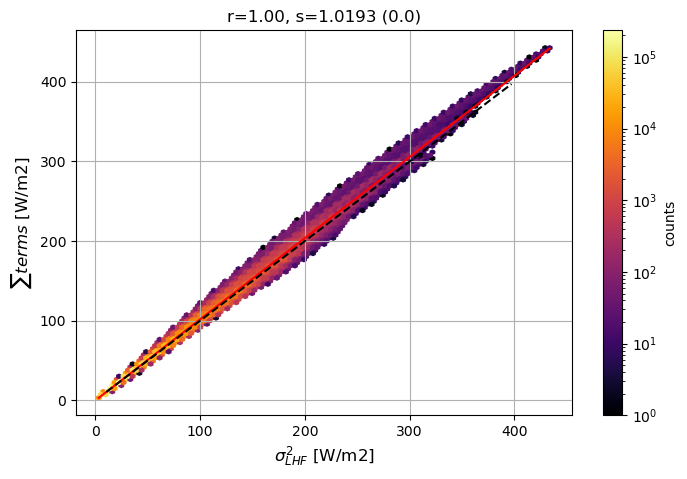

In [103]:
t = 0
density_scatter(var_lhf,var_lhf_sum,'$\\sigma_{LHF}^2$ [W/m2]','$\\sum terms$ [W/m2]')
ics = [np.nanpercentile(var_lhf,5),np.nanpercentile(var_lhf,99.99)]
print(ics)
plt.plot(ics,ics,'k--')

# plt.savefig('/venus/tesi_ale/img_EU/VARIANCE_LH/daily/FEB/MATTE_band-pass_scatterVar_150-60_dailyMeans_lhfRH.png')

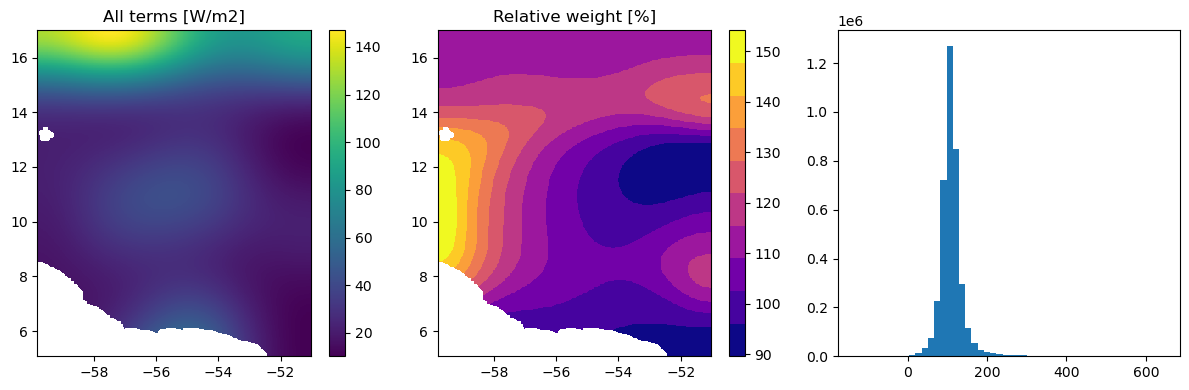

In [30]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)

t = 0

# pc = axs[0].pcolormesh(lon,lat,np.nanmean(sst_terms+non_sst_terms, axis=0),shading='nearest')
pc = axs[0].pcolormesh(lon,lat,(sst_terms+non_sst_terms)[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('All terms [W/m2]')

pc = axs[1].pcolormesh(lon,lat,((sst_terms+non_sst_terms)*100/var_lhf)[t],shading='nearest',cmap=cmap)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist(((sst_terms+non_sst_terms)*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

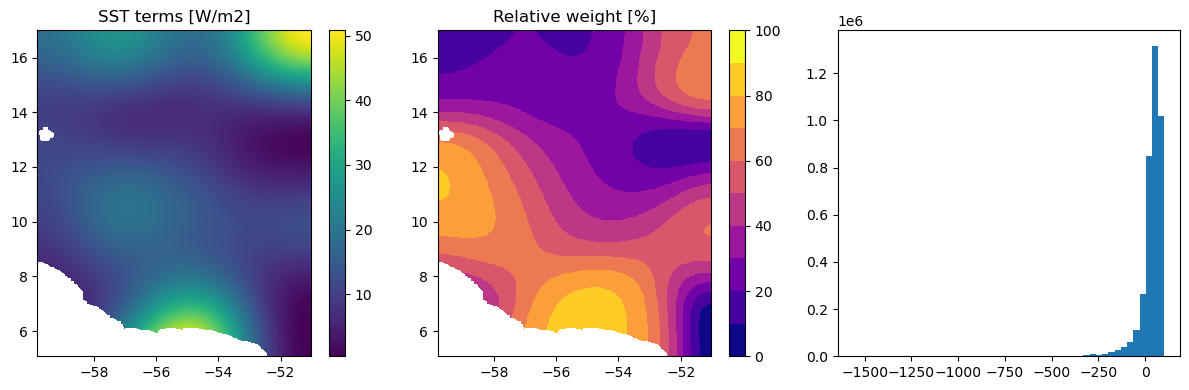

In [31]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)

t = 0

pc = axs[0].pcolormesh(lon,lat,sst_terms[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('SST terms [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(sst_terms*100/var_lhf)[t],shading='nearest',cmap=cmap,vmin=0,vmax=100)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist(((sst_terms)*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

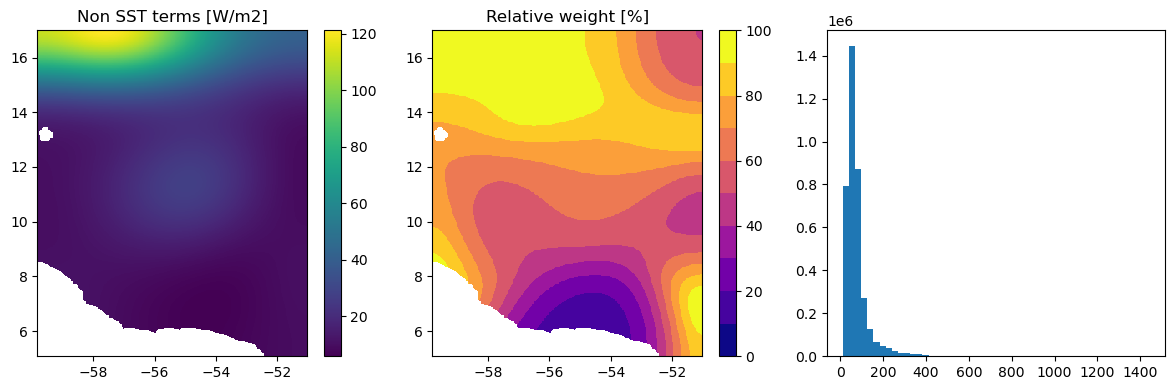

In [32]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)

t = 0

pc = axs[0].pcolormesh(lon,lat,non_sst_terms[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('Non SST terms [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(non_sst_terms*100/var_lhf)[t],shading='nearest',cmap=cmap,vmin=0,vmax=100)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist(((non_sst_terms)*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

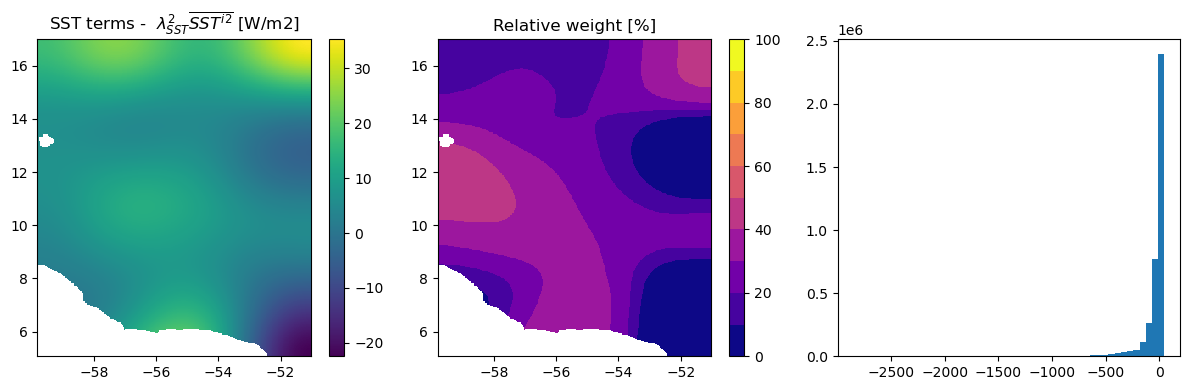

In [33]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)

t = 0

field_to_plot = sst_terms-lambda_sst**2*var_sst

pc = axs[0].pcolormesh(lon,lat,field_to_plot[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('SST terms -  $\\lambda_{SST}^2 \\overline{SST^{i2}}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(field_to_plot*100/var_lhf)[t],shading='nearest',cmap=cmap,vmin=0,vmax=100)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist(((field_to_plot)*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

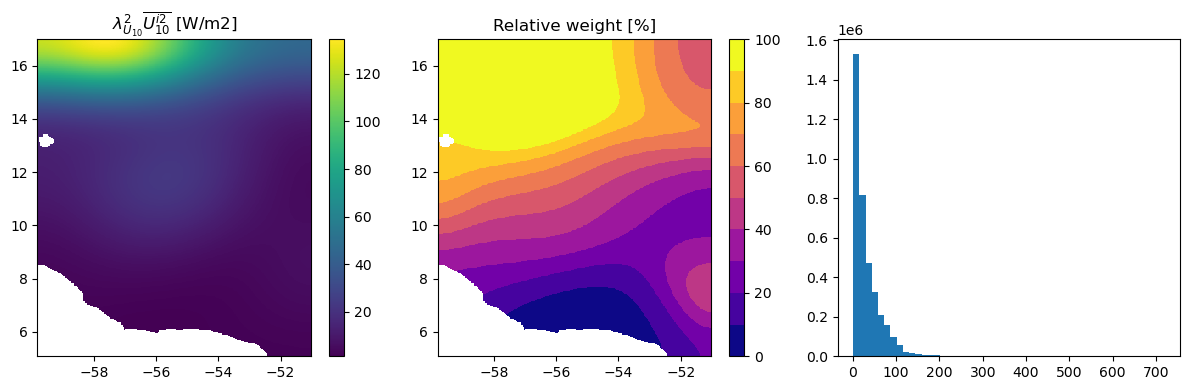

In [34]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)

t = 0 

pc = axs[0].pcolormesh(lon,lat,(lambda_U**2*var_U)[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\\lambda_{U_{10}}^2 \\overline{U_{10}^{i2}}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(lambda_U**2*var_U*100/var_lhf)[t],shading='nearest',cmap=cmap,vmin=0,vmax=100)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist((lambda_U**2*var_U*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

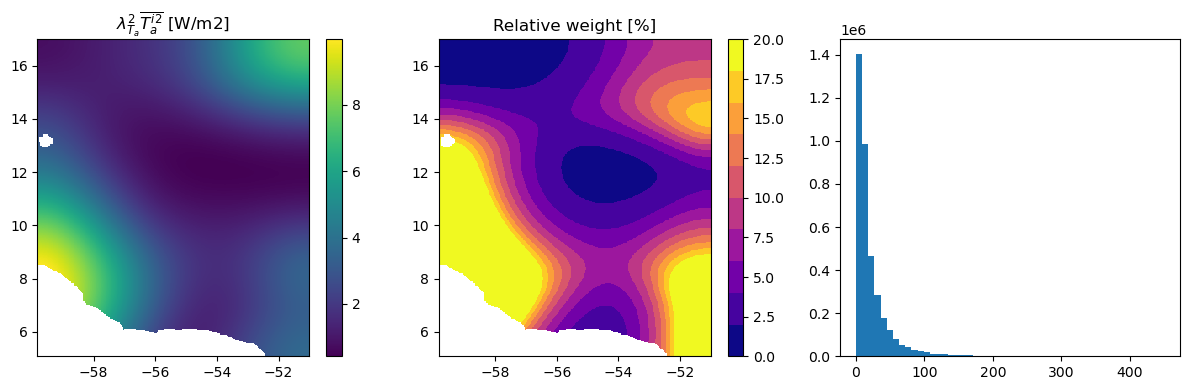

In [35]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)
t = 0 

pc = axs[0].pcolormesh(lon,lat,(lambda_ta**2*var_ta)[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\\lambda_{T_a}^2 \\overline{T_{a}^{i2}}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(lambda_ta**2*var_ta*100/var_lhf)[t],shading='nearest',cmap=cmap,vmin=0,vmax=20)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist((lambda_ta**2*var_ta*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

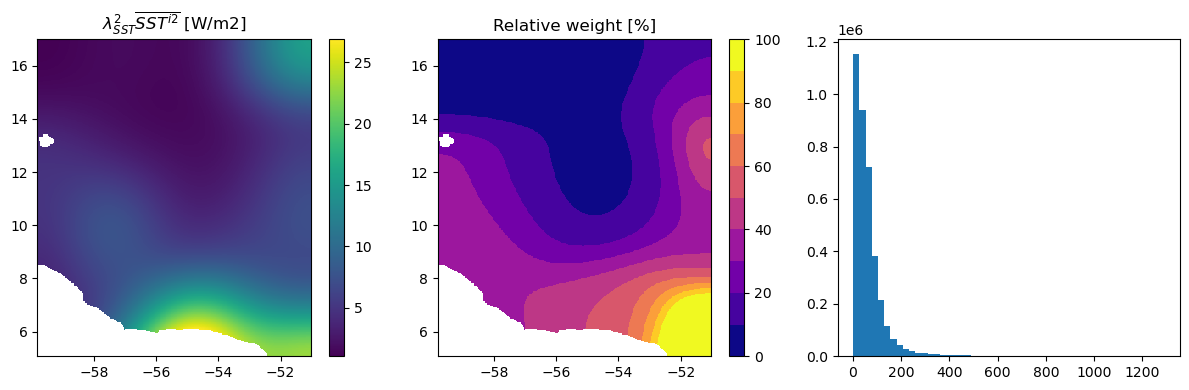

In [36]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)
t = 0

pc = axs[0].pcolormesh(lon,lat,(lambda_sst**2*var_sst)[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\\lambda_{SST}^2 \\overline{SST^{i2}}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(lambda_sst**2*var_sst*100/var_lhf)[t],shading='nearest',cmap=cmap,vmin=0,vmax=100)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist((lambda_sst**2*var_sst*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

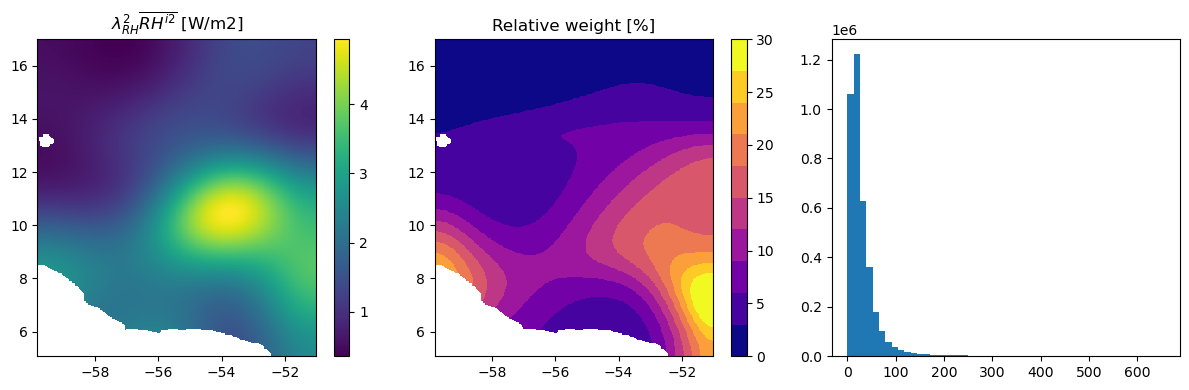

In [37]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
cmap = cm.get_cmap('plasma',10)
t = 0

pc = axs[0].pcolormesh(lon,lat,(lambda_RH**2*var_RH)[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\\lambda_{RH}^2 \\overline{RH^{i2}}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(lambda_RH**2*var_RH*100/var_lhf)[t],shading='nearest',cmap=cmap,vmin=0,vmax=30)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist((lambda_RH**2*var_RH*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

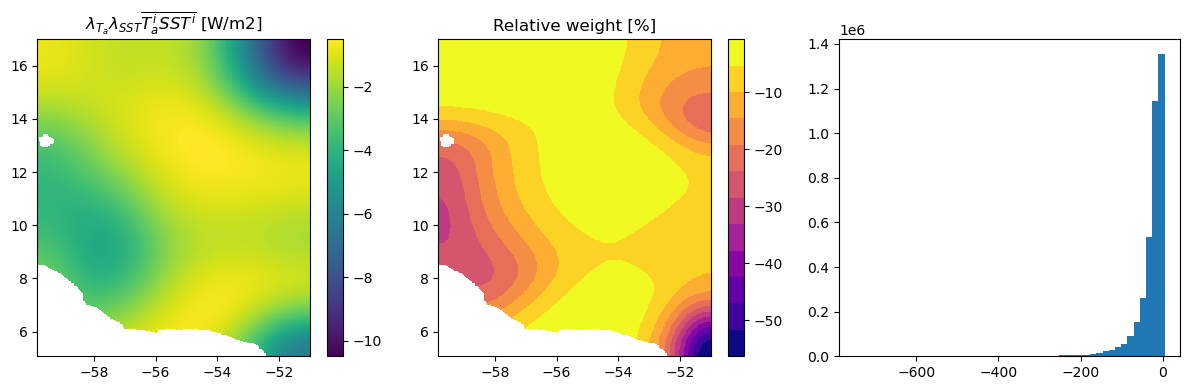

In [38]:
# Look at the covariance SST terms.

fig, axs = plt.subplots(1,3,figsize=(12,4))
field_to_plot = lambda_ta*lambda_sst*covar_ta_sst
t = 0 

cmap = cm.get_cmap('plasma',12)

pc = axs[0].pcolormesh(lon,lat,field_to_plot[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\\lambda_{T_a}\\lambda_{SST} \\overline{T_{a}^{i}SST^i}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(field_to_plot*100/var_lhf)[t],shading='nearest',cmap=cmap)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist((field_to_plot*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

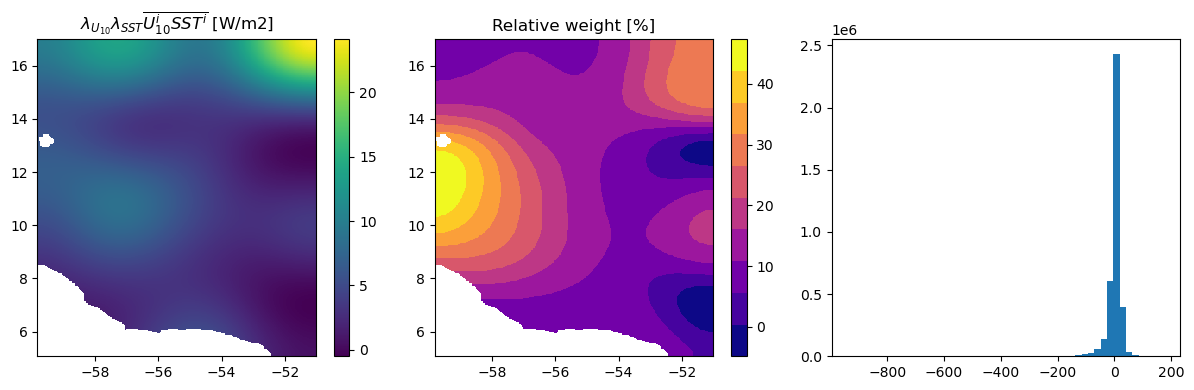

In [39]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
field_to_plot = lambda_U*lambda_sst*covar_U_sst
cmap = cm.get_cmap('plasma',10)

t = 0

pc = axs[0].pcolormesh(lon,lat,field_to_plot[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\\lambda_{U_{10}}\\lambda_{SST} \\overline{U_{10}^{i}SST^i}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(field_to_plot*100/var_lhf)[t],shading='nearest',cmap=cmap)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist((field_to_plot*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

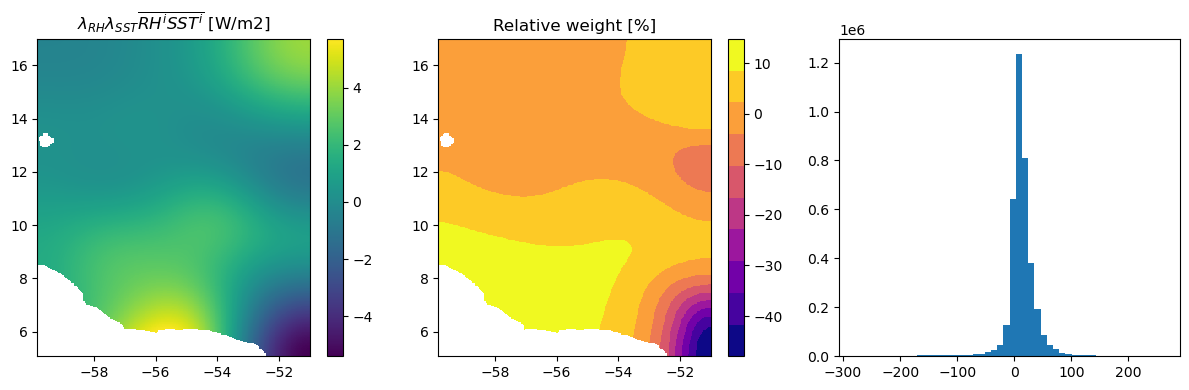

In [40]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
field_to_plot = lambda_RH*lambda_sst*covar_RH_sst
cmap = cm.get_cmap('plasma',10)
t = 0 

pc = axs[0].pcolormesh(lon,lat,field_to_plot[t],shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('$\\lambda_{RH}\\lambda_{SST} \\overline{RH^{i}SST^i}$ [W/m2]')

pc = axs[1].pcolormesh(lon,lat,(field_to_plot*100/var_lhf)[t],shading='nearest',cmap=cmap)
fig.colorbar(pc,ax=axs[1])
axs[1].set_title('Relative weight [%]')

axs[2].hist((field_to_plot*100/var_lhf).flatten(),bins=50)

plt.tight_layout()

In [104]:
list_vars = [lambda_sst, lambda_U, lambda_ta, lambda_RH, lambda_q, 
             var_lhf, var_sst, var_U, var_ta, var_RH, 
             covar_U_sst, covar_ta_sst, covar_RH_sst, covar_U_ta,
             covar_U_RH, covar_ta_RH, covar_lhf_sst, covar_U_q, covar_q_sst, var_qa, 
             sst_prime, ta_prime, qa_prime, U_prime, RH_prime]

for x in list_vars:
    print(x.shape)

(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)
(29, 446, 323)


In [105]:
import pandas as pd
time = pd.date_range(start='2/1/2020', end='2/29/2020')

list_vars = [lambda_sst, lambda_U, lambda_ta, lambda_RH, lambda_q, 
             var_lhf, var_sst, var_U, var_ta, var_RH, 
             covar_U_sst, covar_ta_sst, covar_RH_sst, covar_U_ta,
             covar_U_RH, covar_ta_RH, covar_lhf_sst, covar_U_q, covar_q_sst, var_qa, 
             sst_prime, ta_prime, qa_prime, U_prime, RH_prime, covar_U_lhf]


name_vars = ['lambda_sst', 'lambda_U', 'lambda_ta', 'lambda_RH', 'lambda_q',
             'var_lhf', 'var_sst', 'var_U', 'var_ta', 'var_RH', 
             'covar_U_sst', 'covar_ta_sst', 'covar_RH_sst', 'covar_U_ta',
             'covar_U_RH', 'covar_ta_RH', 'covar_lhf_sst', 'covar_U_q', 'covar_q_sst', 'var_qa', 
             'sst_prime', 'ta_prime', 'qa_prime', 'U_prime', 'RH_prime', 'covar_U_lhf']


if len(list_vars) == len(name_vars):
    print('var lists ok')
    ds_out = xr.Dataset()#coords={'day':time})

    for i in range(len(name_vars)):
        ds_out[name_vars[i]] = xr.DataArray(list_vars[i], name=name_vars[i],\
                                            dims=['day', 'lat', 'lon'])
else:
    print('something missing in either of the two var lists')

var lists ok


In [106]:
print(dir_bulk)
sigma, sigma_sub

True


(50, 20)

In [107]:
ds_out.attrs['description'] = 'MATTE band-pass 150 60, daily means, DIR formulation'

In [108]:
fout = '/venus/tesi_ale/data_EU/VARIANCE_LHF/daily/FEB/ForCouComparison/MATTE_band-pass_lhfDIR_dailyMeans_all.nc'
ds_out.to_netcdf(fout)
ds_out.close()
del ds_out

Text(0.5, 1.0, 'Latent heat flux [W/m2]')

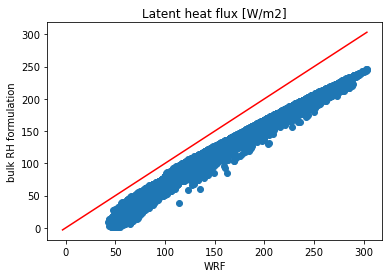

In [17]:
# If we use the formulation with the RH explicitly. Here we are assumign DT << Ta.

lhf_rh = beta*U_ff*(DT_ff*dq_sat_dt(ta_ff,p0)+(1-RH_ff)*q_sat(ta_ff,p0))

plt.scatter(lh_wrf,lhf_rh)
plt.plot([np.min(lh_wrf),np.max(lh_wrf)],[np.min(lh_wrf),np.max(lh_wrf)],'r')
plt.ylabel('bulk RH formulation')
plt.xlabel('WRF')
plt.title('Latent heat flux [W/m2]')

(array([7.800e+01, 4.570e+02, 1.127e+03, 1.554e+03, 1.885e+03, 1.904e+03,
        1.595e+03, 1.506e+03, 1.565e+03, 1.540e+03, 1.828e+03, 1.986e+03,
        2.381e+03, 2.783e+03, 2.729e+03, 3.049e+03, 3.421e+03, 3.614e+03,
        3.710e+03, 4.090e+03, 4.382e+03, 5.206e+03, 6.151e+03, 7.336e+03,
        8.047e+03, 8.012e+03, 8.340e+03, 7.845e+03, 7.279e+03, 7.022e+03,
        6.770e+03, 6.844e+03, 7.020e+03, 6.825e+03, 6.675e+03, 6.648e+03,
        5.738e+03, 5.057e+03, 4.189e+03, 3.292e+03, 2.531e+03, 1.647e+03,
        1.048e+03, 6.650e+02, 3.600e+02, 1.960e+02, 1.060e+02, 5.000e+01,
        1.900e+01, 7.000e+00]),
 array([  0.64371346,   5.56725561,  10.49079775,  15.4143399 ,
         20.33788204,  25.26142419,  30.18496633,  35.10850848,
         40.03205062,  44.95559277,  49.87913491,  54.80267706,
         59.7262192 ,  64.64976135,  69.57330349,  74.49684564,
         79.42038778,  84.34392993,  89.26747207,  94.19101422,
         99.11455636, 104.03809851, 108.96164065, 113.88

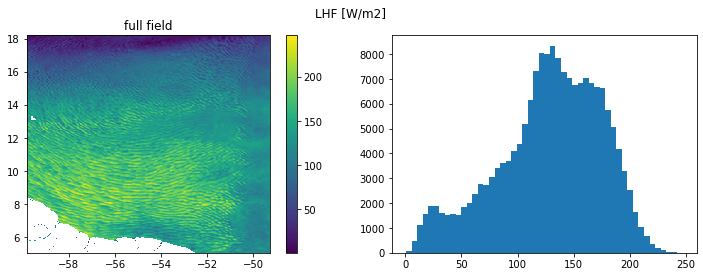

In [18]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('LHF [W/m2]')

pc = axs[0].pcolormesh(lon,lat,lhf_rh,shading='nearest')
fig.colorbar(pc,ax=axs[0])
axs[0].set_title('full field')

axs[1].hist(lhf_rh.flatten(),bins=50)

#pc = axs[1,0].pcolormesh(lon,lat,DT_bar,shading='nearest')
#fig.colorbar(pc,ax=axs[1,0])
#axs[1,0].set_title('large-scale field')

#sst_prime = sst_ff-sst_bar
#pc = axs[1,1].pcolormesh(lon,lat,DT_prime,shading='nearest',cmap='seismic',vmin=-2,vmax=2)
#fig.colorbar(pc,ax=axs[1,1])
#axs[1,1].set_title('spatial anomaly')

<ipython-input-3-88b4efd19e4e>:10: RuntimeWarning: invalid value encountered in true_divide
  return e_sat0 * np.exp(B*t/(C+t))


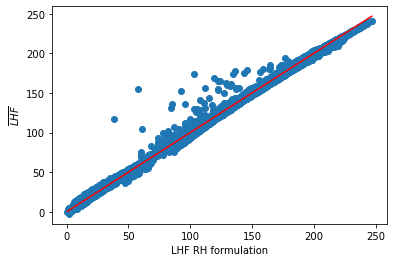

In [19]:
lhf_bar = beta*U_bar*(DT_bar*dq_sat_dt(ta_bar,p0)+(1-RH_bar)*q_sat(ta_bar,p0))

#plt.scatter(lhf_rh,lhf_bar)
plt.plot([np.nanmin(lhf_rh),np.nanmax(lhf_rh)],[np.nanmin(lhf_rh),np.nanmax(lhf_rh)],'r')
plt.xlabel('LHF RH formulation')
plt.ylabel('$\\overline{LHF}$')

lambda_U = beta*(DT_bar*dq_sat_dt(ta_bar,p0)+(1-RH_bar)*q_sat(ta_bar,p0))
lambda_DT = beta*U_bar*dq_sat_dt(ta_bar,p0)
lambda_ta = beta*U_bar*(DT_bar*dq2_sat_dt2(ta_bar,p0)+(1-RH_bar)*dq_sat_dt(ta_bar,p0))
lambda_RH = -beta*U_bar*q_sat(ta_bar,p0)

plt.scatter(lhf_rh,lhf_bar+lambda_U*U_prime+lambda_DT*DT_prime+lambda_ta*ta_prime+lambda_RH*RH_prime)

(array([1760., 1654., 1698., 1799., 1862., 2013., 3910., 3045., 2521.,
        2285., 2161., 2080., 2016., 1992., 1964., 1970., 1976., 1977.,
        1998., 2052., 2073., 2116., 2200., 2264., 2358., 2449., 2600.,
        2767., 2926., 4301., 5019., 5657., 7002., 5557., 5104., 4958.,
        5088., 5013., 4893., 4762., 4739., 4737., 4802., 4947., 5122.,
        5417., 5875., 6125., 6401., 8104.]),
 array([ 43.43686818,  46.18902013,  48.94117207,  51.69332401,
         54.44547595,  57.19762789,  59.94977984,  62.70193178,
         65.45408372,  68.20623566,  70.95838761,  73.71053955,
         76.46269149,  79.21484343,  81.96699537,  84.71914732,
         87.47129926,  90.2234512 ,  92.97560314,  95.72775508,
         98.47990703, 101.23205897, 103.98421091, 106.73636285,
        109.4885148 , 112.24066674, 114.99281868, 117.74497062,
        120.49712256, 123.24927451, 126.00142645, 128.75357839,
        131.50573033, 134.25788227, 137.01003422, 139.76218616,
        142.5143381 , 14

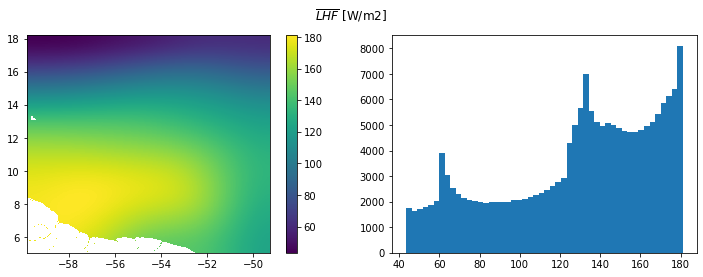

In [20]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('$\\overline{LHF}$ [W/m2]')

pc = axs[0].pcolormesh(lon,lat,lhf_bar,shading='nearest')
fig.colorbar(pc,ax=axs[0])

axs[1].hist(lhf_bar.flatten(),bins=50)

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.0000e+00, 1.4000e+01,
        6.0000e+00, 1.0000e+01, 1.2000e+01, 1.6000e+01, 1.8000e+01,
        1.5000e+01, 1.5000e+01, 1.4000e+01, 1.1000e+01, 7.0000e+00,
        1.1000e+01, 2.0000e+00, 1.8000e+01, 3.4000e+01, 2.0200e+02,
        5.5600e+02, 6.7400e+02, 8.5600e+02, 1.0730e+03, 1.8180e+03,
        3.0580e+03, 4.3880e+03, 5.8350e+03, 7.9650e+03, 1.3168e+04,
        1.8254e+04, 2.4791e+04, 2.7339e+04, 2.3023e+04, 1.7407e+04,
        1.1394e+04, 7.2220e+03, 4.2550e+03, 2.4200e+03, 1.2160e+03,
        5.3300e+02, 2.7500e+02, 1.2200e+02, 4.4000e+01, 6.0000e+00]),
 array([-1.51465298e+02, -1.47370164e+02, -1.43275031e+02, -1.39179898e+02,
        -1.35084765e+02, -1.30989631e+02, -1.26894498e+02, -1.22799365e+02,
        -1.18704232e+02, -1.14609098e+02, -1.10513965e+02, -1.06418832e+02,
        -1.02323699e+02, -9.82285656e+01, -9.41334324e+01, -9.00382991e+01,
        -8.594

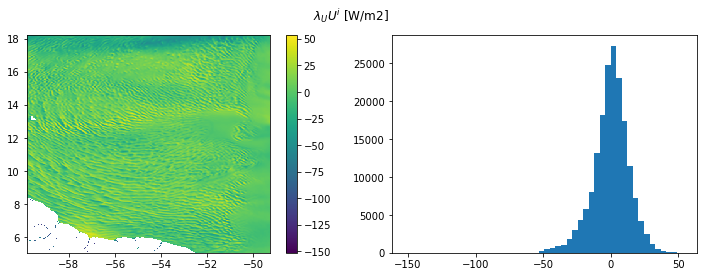

In [21]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('$\\lambda_UU^i$ [W/m2]')

field = lambda_U*U_prime
pc = axs[0].pcolormesh(lon,lat,field,shading='nearest')
fig.colorbar(pc,ax=axs[0])

axs[1].hist(field.flatten(),bins=50)

(array([1.8000e+01, 6.1000e+01, 1.8300e+02, 2.6500e+02, 3.3000e+02,
        5.7500e+02, 1.0720e+03, 1.7800e+03, 2.9840e+03, 5.5930e+03,
        9.5910e+03, 1.5885e+04, 2.6138e+04, 3.7606e+04, 2.9208e+04,
        1.8964e+04, 1.2501e+04, 7.4260e+03, 4.0500e+03, 2.0620e+03,
        8.7600e+02, 3.6700e+02, 1.7200e+02, 1.2000e+02, 6.1000e+01,
        4.8000e+01, 1.5000e+01, 1.0000e+01, 7.0000e+00, 9.0000e+00,
        1.0000e+01, 1.2000e+01, 1.2000e+01, 1.9000e+01, 9.0000e+00,
        8.0000e+00, 1.0000e+01, 3.0000e+00, 2.0000e+00, 9.0000e+00,
        1.2000e+01, 5.0000e+00, 5.0000e+00, 5.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([-37.14553757, -34.43492967, -31.72432178, -29.01371388,
        -26.30310599, -23.59249809, -20.8818902 , -18.1712823 ,
        -15.4606744 , -12.75006651, -10.03945861,  -7.32885072,
         -4.61824282,  -1.90763493,   0.80297297,   3.51358086,
          6.22418876,   8.93479666,  11.64540455,  14.35601245

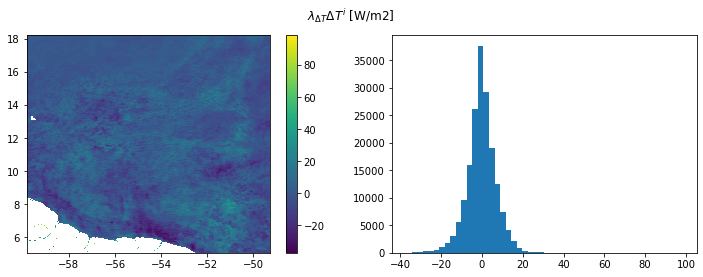

In [22]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('$\\lambda_{\\Delta T}\\Delta T^i$ [W/m2]')

field = lambda_DT*DT_prime
pc = axs[0].pcolormesh(lon,lat,field,shading='nearest')
fig.colorbar(pc,ax=axs[0])

axs[1].hist(field.flatten(),bins=50)

(array([2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 6.0000e+00, 9.0000e+00, 5.0000e+00,
        6.0000e+00, 5.0000e+00, 1.2000e+01, 4.0000e+00, 1.9000e+01,
        1.0000e+01, 5.0000e+00, 8.0000e+00, 9.0000e+00, 1.2000e+01,
        6.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00, 1.3000e+01,
        2.1000e+01, 2.5000e+01, 6.6000e+01, 2.6800e+02, 6.3600e+02,
        1.4970e+03, 2.8890e+03, 5.8450e+03, 1.1960e+04, 2.0172e+04,
        3.7302e+04, 3.9707e+04, 2.6407e+04, 1.5847e+04, 8.6070e+03,
        4.3430e+03, 1.7850e+03, 3.7900e+02, 1.4400e+02, 4.3000e+01]),
 array([-2.40557746e+01, -2.34692403e+01, -2.28827061e+01, -2.22961718e+01,
        -2.17096375e+01, -2.11231032e+01, -2.05365690e+01, -1.99500347e+01,
        -1.93635004e+01, -1.87769661e+01, -1.81904319e+01, -1.76038976e+01,
        -1.70173633e+01, -1.64308290e+01, -1.58442948e+01, -1.52577605e+01,
        -1.467

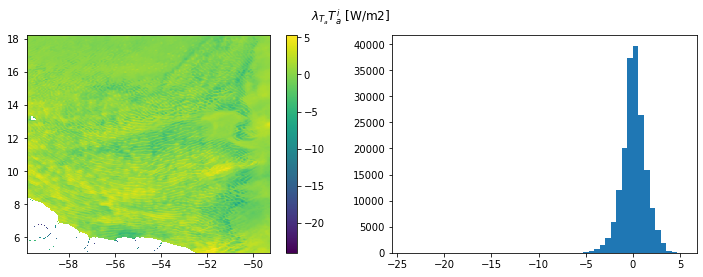

In [23]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('$\\lambda_{T_a} T_a^i$ [W/m2]')

field = lambda_ta*ta_prime
pc = axs[0].pcolormesh(lon,lat,field,shading='nearest')
fig.colorbar(pc,ax=axs[0])

axs[1].hist(field.flatten(),bins=50)

(array([3.0000e+00, 2.0000e+00, 4.0000e+00, 9.0000e+00, 9.0000e+00,
        5.0000e+00, 1.7000e+01, 1.1000e+01, 1.2000e+01, 1.4000e+01,
        1.4000e+01, 4.1000e+01, 1.7900e+02, 4.7000e+02, 2.5580e+03,
        1.0034e+04, 1.7045e+04, 3.1786e+04, 5.2833e+04, 3.1274e+04,
        1.4645e+04, 8.1740e+03, 4.7270e+03, 2.4310e+03, 1.1310e+03,
        4.3200e+02, 1.7200e+02, 4.2000e+01, 1.2000e+01, 5.0000e+00,
        4.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-70.67570195, -66.87795919, -63.08021643, -59.28247367,
        -55.48473091, -51.68698815, -47.88924539, -44.09150263,
        -40.29375987, -36.49601711, -32.69827435, -28.90053159,
        -25.10278883, -21.30504608, -17.50730332, -13.70956056,
         -9.9118178 ,  -6.11407504,  -2.31633228,   1.48141048

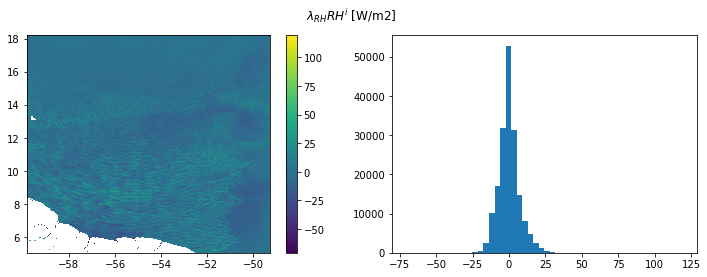

In [24]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle('$\\lambda_{RH}RH^i$ [W/m2]')

field = lambda_RH*RH_prime
pc = axs[0].pcolormesh(lon,lat,field,shading='nearest')
fig.colorbar(pc,ax=axs[0])

axs[1].hist(field.flatten(),bins=50)

0.0019749681004142465
0.0
5.7633663540335005e-05
0.0011138858503918327


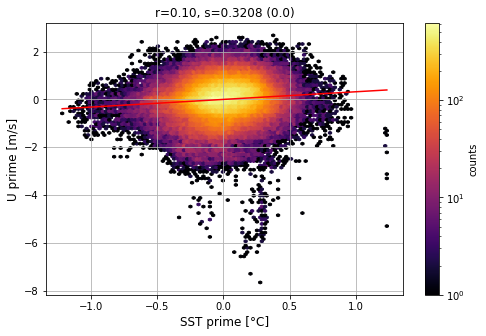

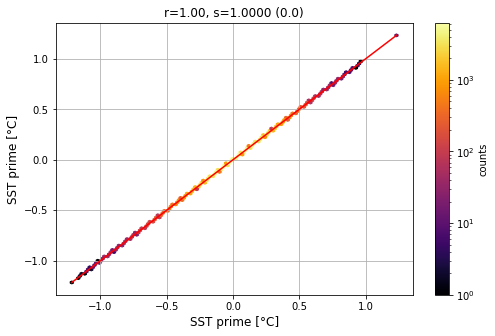

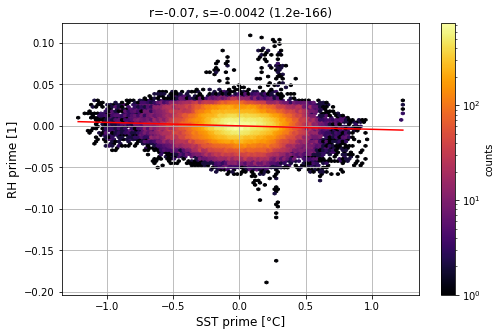

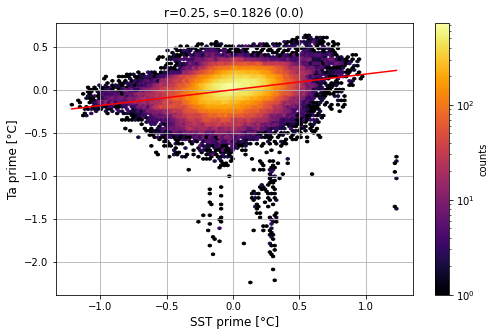

In [66]:
# Now look at the correlations with sst_prime.

density_scatter(sst_prime,U_prime,'SST prime [°C]','U prime [m/s]')
density_scatter(sst_prime,sst_prime,'SST prime [°C]','SST prime [°C]')
density_scatter(sst_prime,RH_prime,'SST prime [°C]','RH prime [1]')
density_scatter(sst_prime,ta_prime,'SST prime [°C]','Ta prime [°C]')

Text(0, 0.5, 'DT prime [°C]')

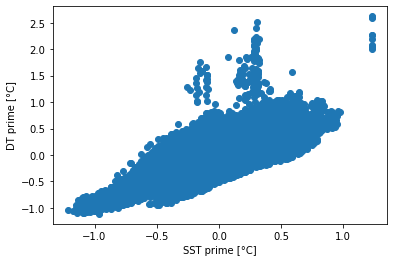

In [29]:
plt.scatter(sst_prime,DT_prime)
plt.xlabel('SST prime [°C]')
plt.ylabel('DT prime [°C]')

Text(0, 0.5, 'Ta prime [°C]')

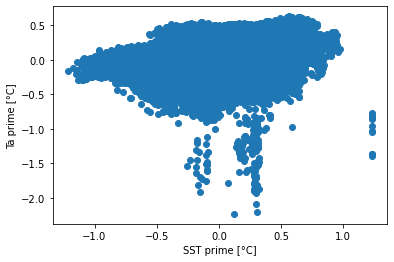

In [30]:
plt.scatter(sst_prime,ta_prime)
plt.xlabel('SST prime [°C]')
plt.ylabel('Ta prime [°C]')

Text(0, 0.5, 'RH prime [1]')

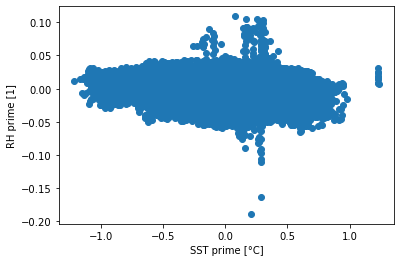

In [31]:
plt.scatter(sst_prime,RH_prime)
plt.xlabel('SST prime [°C]')
plt.ylabel('RH prime [1]')